### https://sakibreza.github.io/TransResUNet

In [2]:
#importing required packages
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg19 import VGG19

#importing required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology


import os
import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
from numpy import zeros, newaxis
%matplotlib inline

# Residual Path

In [30]:
def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)
    
    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

# Decoder Block

In [31]:
def decoder_block(inputs, mid_channels, out_channels):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # Upsampling (nearest neighbor interpolation) layer
    db = UpSampling2D(size=(2, 2))(inputs)
    # First conv2D layer 
    db = Conv2D(mid_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db

# Main Architecture

In [32]:
input_size=(512, 512, 1)

# Input 
inputs = Input(input_size)
inp = inputs
input_shape = input_size

# Handling input channels 
# input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
if input_size[-1] < 3:
    inp = Conv2D(3, 1)(inputs)                         
    input_shape = (input_size[0], input_size[0], 3)  
else:
    inp = inputs
    input_shape = input_size

In [33]:
VGG19(include_top=False, weights='imagenet', input_shape=input_shape).summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [34]:
def TransResUNet(input_size=(512, 512, 3)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)
    inp = inputs
    input_shape = input_size
    
    # Handling input channels 
    # input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(inputs)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = inputs
        input_shape = input_size

    # VGG16 with imagenet weights
    encoder = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc3)
    center = decoder_block(center, 512, 256)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, center], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)
    out = Conv2D(2, (1, 1), padding='same')(dec1)
    # Final model
    model = Model(inputs=[inputs], outputs=[out])
    
    return model

In [35]:
model = TransResUNet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[1][0]']           
                                )                                                           

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'], run_eagerly=True)

In [3]:
input_dir = '.\\jsrt_src\\train_augmented\\xray\\'
target_dir = '.\\jsrt_src\\train_augmented\\label\\'

# sorted함수를 사용하여 정렬된 파일 리스트를 반환
# 이터러블 객체도 받을 수 있음 
image_list = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])

mask_list = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
    ])

print( len(image_list), '/', len(mask_list) )

20846 / 20846


In [4]:
val_input_dir = '.\\jsrt_src\\test\\xray\\'
val_target_dir = '.\\jsrt_src\\test\\label\\'

val_image_list = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
    ]
)

val_mask_list = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
    ]
)

print( len(val_image_list), '/', len(val_mask_list) )

2126 / 2126


In [13]:
mask[:, :, 0]

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Text(0.5, 1.0, 'Segmentation')

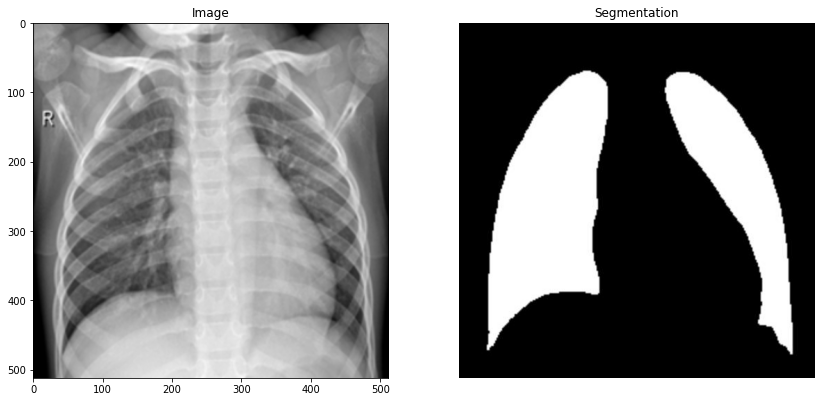

In [5]:
N = 4000
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0])for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
plt.axis('off')
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [40]:
#Train
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [41]:
len(image_list_ds)

20846

In [42]:
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'.\\DataSet\\XRAY_ALL\\train\\xray\\1.png', shape=(), dtype=string)
tf.Tensor(b'.\\DataSet\\XRAY_ALL\\train\\label\\1.png', shape=(), dtype=string)


In [43]:
#validation
val_image_list_ds = tf.data.Dataset.list_files(val_image_list, shuffle=False)
val_mask_list_ds = tf.data.Dataset.list_files(val_mask_list, shuffle=False)

val_image_filenames = tf.constant(val_image_list)
val_mask_filenames = tf.constant(val_mask_list)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_filenames, val_mask_filenames))

for image, mask in val_dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'.\\DataSet\\XRAY_ALL\\test\\xray\\0.png', shape=(), dtype=string)
tf.Tensor(b'.\\DataSet\\XRAY_ALL\\test\\label\\0.png', shape=(), dtype=string)


In [44]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (512, 512), method='nearest')
    input_mask = tf.image.resize(mask, (512, 512), method='nearest')

    return input_image, input_mask/255


#Train dataset
image_ds = dataset.map(process_path)
train_processed_image_ds = image_ds.map(preprocess)

#validation dataset
val_image_ds = val_dataset.map(process_path)
val_processed_image_ds = val_image_ds.map(preprocess)

In [45]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Post Processed']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'gray')
        plt.axis('off')
    plt.show()

(512, 512, 3) 1.0
(512, 512, 1) 1.0


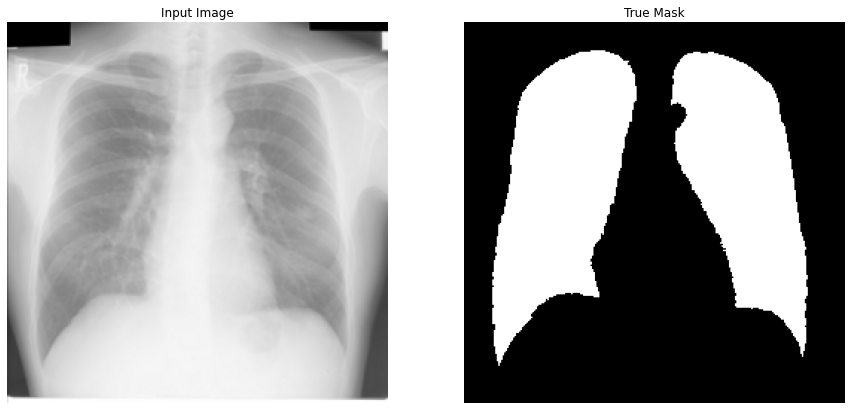

In [48]:
for image, mask in train_processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(image.shape, image.numpy().max())
    print(mask.shape, mask.numpy().max())

display([sample_image, sample_mask])

In [19]:
EPOCHS = 50
VAL_SUBSPLITS = 3
BUFFER_SIZE = 500
BATCH_SIZE = 2
train_processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_processed_image_ds.cache().batch(BATCH_SIZE)

In [24]:
train_dataset

<BatchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

In [20]:
print(train_processed_image_ds.element_spec)

(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))


In [21]:
# Call-back 함수
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='./MODEL/VGG19-Augmentation-{epoch:03d}-{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5',
            monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=2, verbose=1, min_lr=1e-8)
# patience(3) 번 동안 validation set에서의 loss가 떨어지지 않으면, learning rate를 0.8만큼 곱해라
# 0.001 -> 0.0008 -> 0.00064 -> 0.00051xx...

CALLBACK = [CP, TB, LR]

In [23]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks = CALLBACK)

c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
10423/10423 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9330
Epoch 00001: val_accuracy improved from -inf to 0.94615, saving model to ./MODEL\VGG19-Augmentation-001-0.0844-0.9330-0.0390-0.9462.hdf5
10423/10423 [==============================] - 4083s 391ms/step - loss: 0.0844 - accuracy: 0.9330 - val_loss: 0.0390 - val_accuracy: 0.9462 - lr: 1.0000e-04
Epoch 2/50
10423/10423 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9429
Epoch 00002: val_accuracy did not improve from 0.94615
10423/10423 [==============================] - 5335s 512ms/step - loss: 0.0561 - accuracy: 0.9429 - val_loss: 0.0339 - val_accuracy: 0.9448 - lr: 1.0000e-04
Epoch 3/50
10423/10423 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9448
Epoch 00003: val_accuracy improved from 0.94615 to 0.94793, saving model to ./MODEL\VGG19-Augmentation-003-0.0499-0.9448-0.0291-0.9479.hdf5
10423/10423 [==============================] - 6039s 5

In [96]:
#model.save_weights('./MODEL/FinalEpoch_VGG19.hdf5')

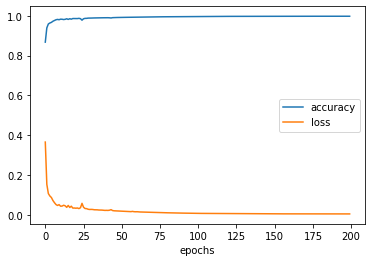

In [38]:
plt.plot(model_history.history['accuracy'], label = 'accuracy')
plt.plot(model_history.history['loss'], label = 'loss')
plt.xlabel('epochs')
plt.legend()

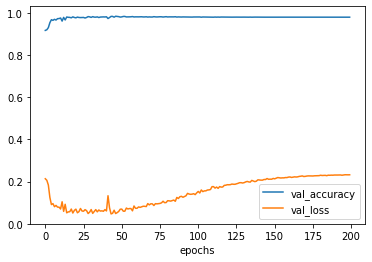

In [39]:
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.legend()

# Post-Processing for Predicted Lung Masks

In [43]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [44]:
def pprocess(img, SE=(10,30), thresh=15000):
    
    """
    pprocess -- function for post-processing

    Arguments:
    img {numpy.ndarray} -- input image 
    SE {tuple} -- eliptical structuring element shape
    thresh {int} -- threshold value, any connected compnents with pixel area below this value will be eliminated

    Returns: 
    final {numpy.ndarray} -- final post-processed image
    """
    
    ##### Post-processing 1: Hole Filling
    img_in = img
    # Thresholding
    # Setting up values >=200 to 0 and values <200 to 255.
    thres, img_thres = cv2.threshold(img_in, 220, 255, cv2.THRESH_BINARY);

    # Copying the thresholded image.
    img_ffill = img_thres.copy()

    # Mask for flood-filling
    # Here, the size should be 2 pixels larger than the orginal image.
    h, w = img_thres.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Flood-fill starts from node (0, 0)
    cv2.floodFill(img_ffill, mask, (0,0), 255);

    # Invert flood-fill resultant image
    img_ffill_inv = cv2.bitwise_not(img_ffill)
  
    # Bitwise OR (equavalent to union) the two images to get the final hole filled image.
    img_out = img_thres | img_ffill_inv
    

    ##### Post-processing 2: Removing Unwanted Components
    img = img_out/255
    img[img>0.5] = 1
    img[img<=0.5] = 0
    img = morphology.remove_small_objects(img.astype('bool'), thresh)
    img = np.array(img*255, dtype=np.uint8)

    
    ##### Post-processing 3: Morphological Opening 
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, SE))
    
    # Returning the final post-processed image
    return img

# Load fine-tuned model weight

In [45]:
os.listdir('MODEL')

['.ipynb_checkpoints',
 'FinalEpoch.hdf5',
 'VGG16-010-0.0232-0.9903-0.0475-0.9830.hdf5',
 'VGG19-047-0.0211-0.9911-0.0485-0.9830.hdf5']

In [50]:
model.load_weights( 'MODEL/VGG19-047-0.0211-0.9911-0.0485-0.9830.hdf5' )
val_test_dataset = val_processed_image_ds.cache().batch(1)

In [66]:
pred_mask = model.predict(image)

In [76]:
pred_mask = model.predict(image)
pred_mask = np.array(create_mask(pred_mask)).astype('int8')

In [77]:
pred_mask.shape

(512, 512, 1)

In [100]:
np.array(mask[0]).max()

1.0

In [103]:
Mask = np.array(mask[0])

In [104]:
Mask.max()

1.0

In [113]:
intersection = np.logical_and(Mask, PostProcess)
union = np.logical_or(Mask, PostProcess)


In [ ]:
pred_

In [130]:
pred_mask = np.array(create_mask(model.predict(image)))

In [132]:
pred_mask.max()

1

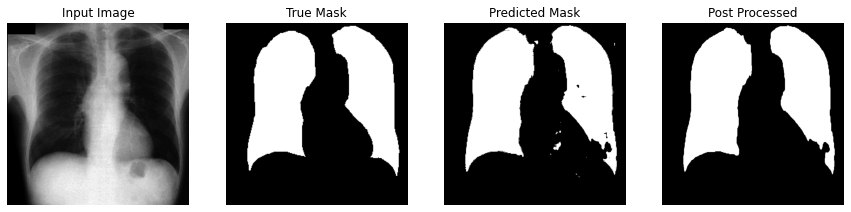

Raw pred mask IOU: 0.9351
Post process IOU: 0.9402


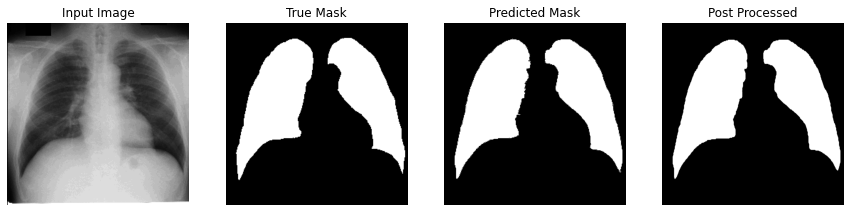

Raw pred mask IOU: 0.9565
Post process IOU: 0.9499


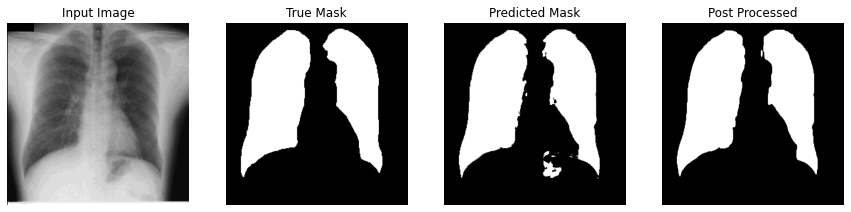

Raw pred mask IOU: 0.9288
Post process IOU: 0.9447


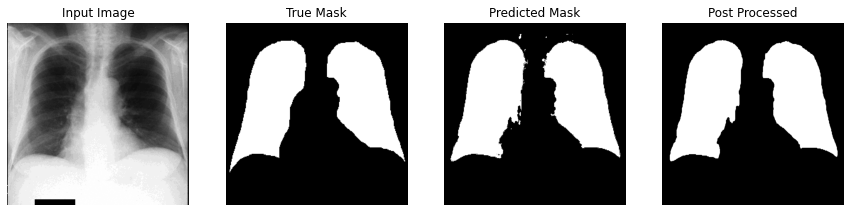

Raw pred mask IOU: 0.9317
Post process IOU: 0.9334


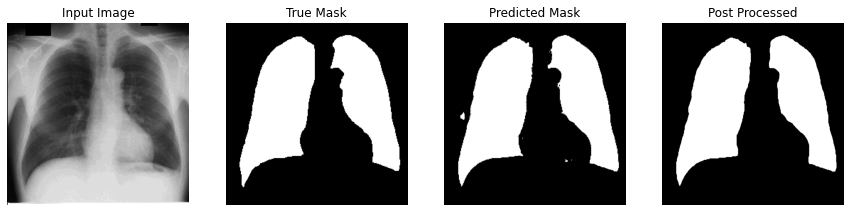

Raw pred mask IOU: 0.9644
Post process IOU: 0.9603


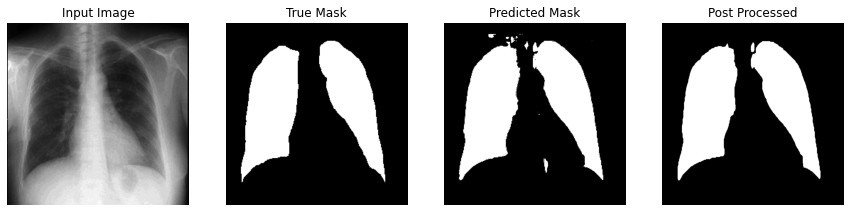

Raw pred mask IOU: 0.936
Post process IOU: 0.9448


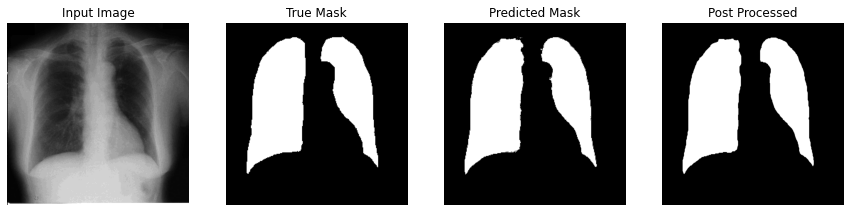

Raw pred mask IOU: 0.9557
Post process IOU: 0.9498


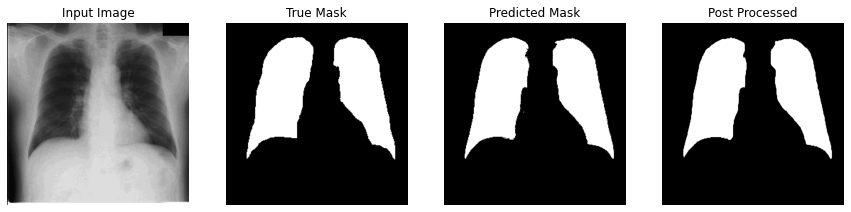

Raw pred mask IOU: 0.9559
Post process IOU: 0.9475


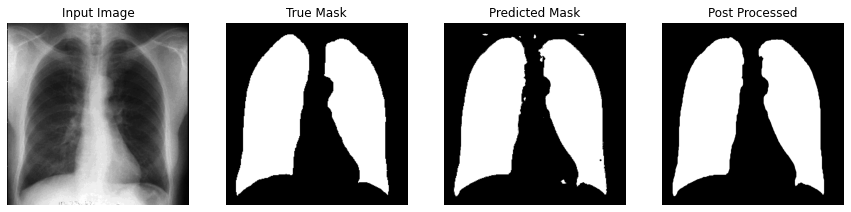

Raw pred mask IOU: 0.9641
Post process IOU: 0.9657


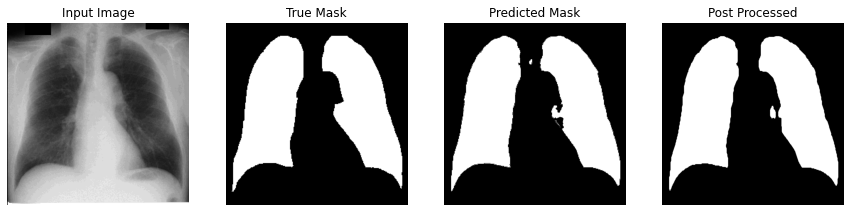

Raw pred mask IOU: 0.9599
Post process IOU: 0.9526


In [133]:
for image, mask in val_test_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask_tmp = np.array(create_mask(model.predict(image)))
    PostProcess = pprocess((np.array(create_mask(pred_mask))[:,:,0]*255).astype('uint8'), SE = (5, 20), thresh = 5000)[:, :, newaxis]/255
    display([image[0], mask[0], create_mask(pred_mask), PostProcess])

    intersection = np.logical_and(mask[0], pred_mask_tmp)
    union = np.logical_or(mask[0], pred_mask_tmp)
    iou_score1 = np.sum(intersection)/np.sum(union)
    print('Raw pred mask IOU:',iou_score1.round(4))

    intersection = np.logical_and(mask[0], PostProcess)
    union = np.logical_or(mask[0], PostProcess)
    iou_score2 = np.sum(intersection)/np.sum(union)
    print('Post process IOU:',iou_score2.round(4))


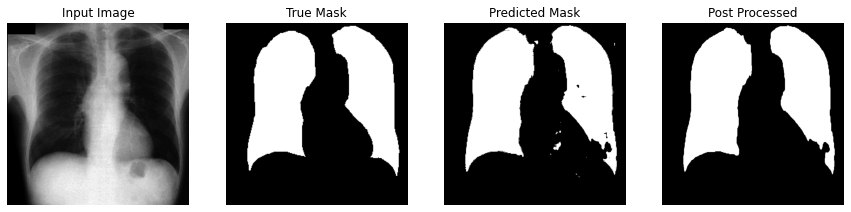

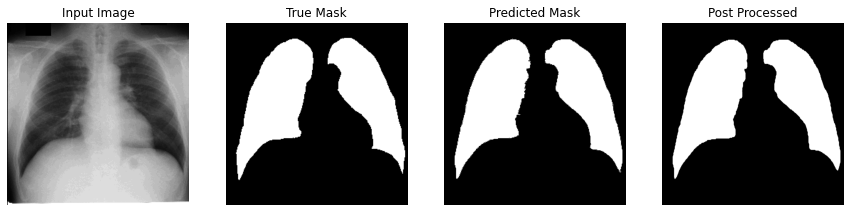

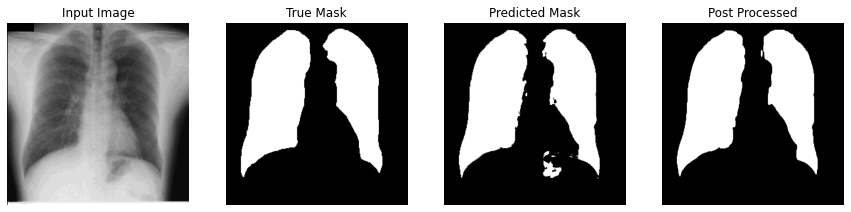

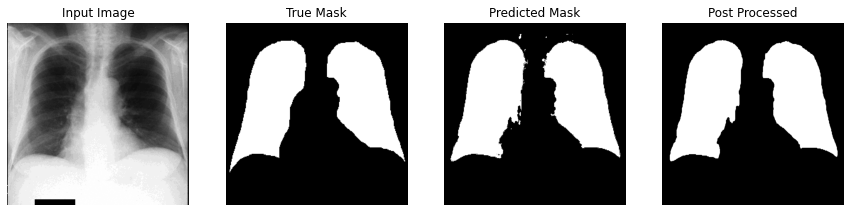

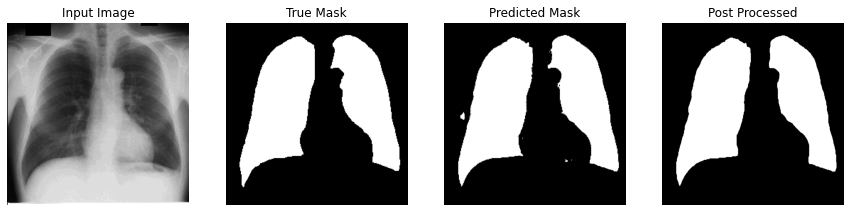

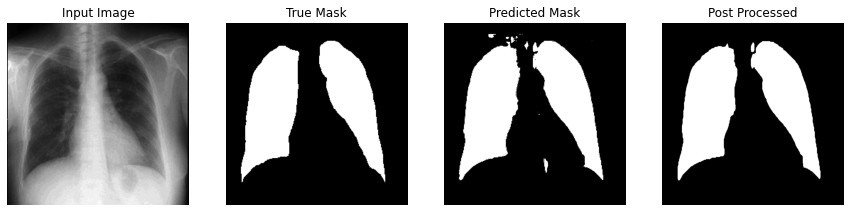

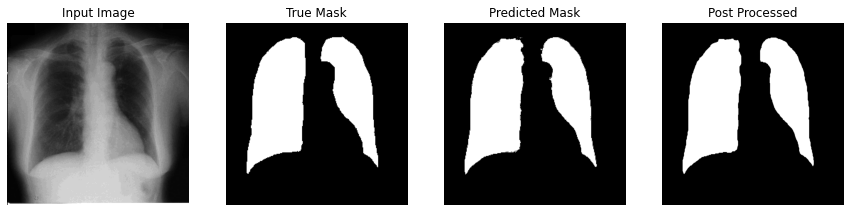

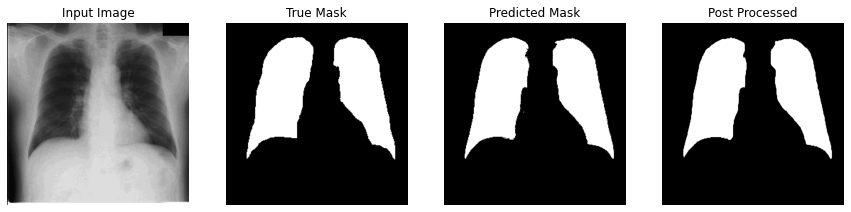

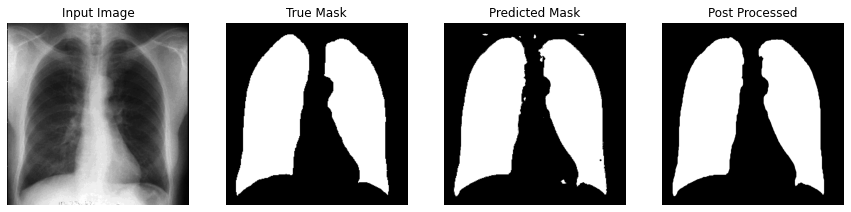

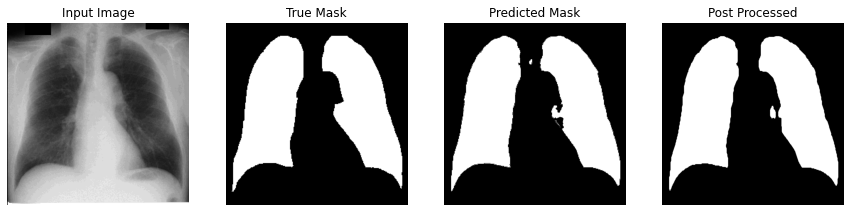

In [48]:
# 훈련이미지와 예측이미지 비교
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            PostProcess = pprocess((np.array(create_mask(pred_mask))[:,:,0]*255).astype('uint8'), SE = (5, 20), thresh = 5000)[:, :, newaxis]
            display([image[0], mask[0], create_mask(pred_mask), PostProcess])
    else:
        display([sample_image, sample_mask/128, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(val_test_dataset, 10)

In [49]:
def display_alpha(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Post Processed']

    plt.subplot(1, len(display_list), 1)

    plt.title(title[0])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]), 'gray')
    plt.axis('off')
    
    for i in range(1, len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]), 'gray')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'jet', alpha=0.3)
        plt.axis('off')
    plt.show()

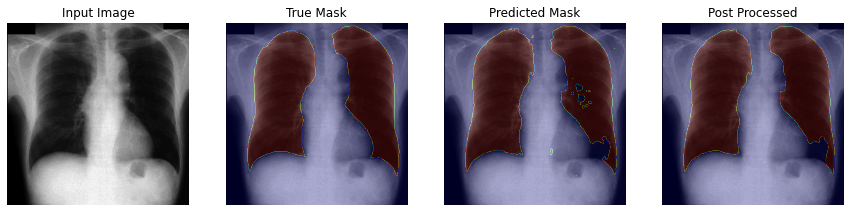

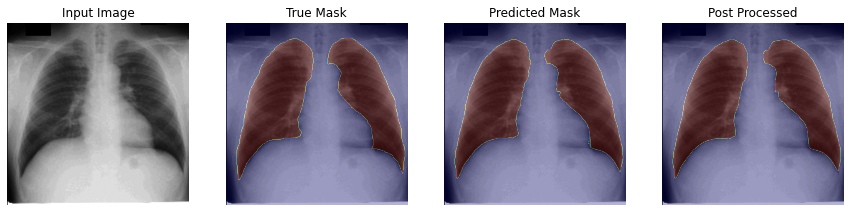

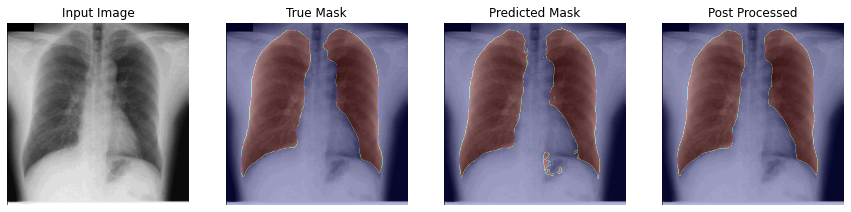

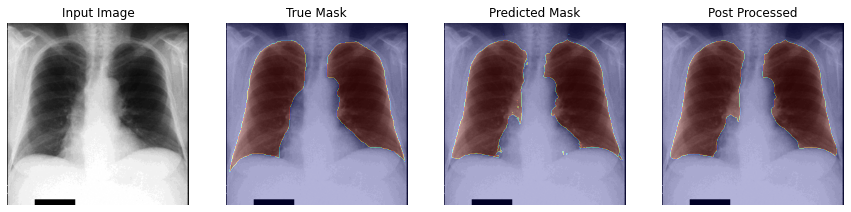

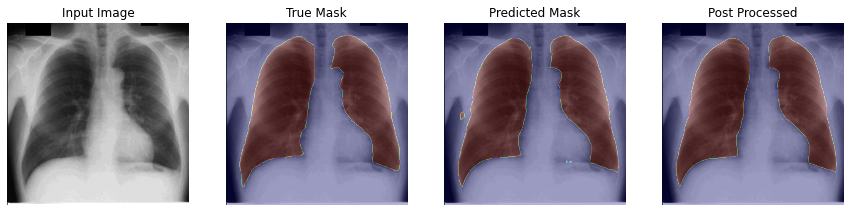

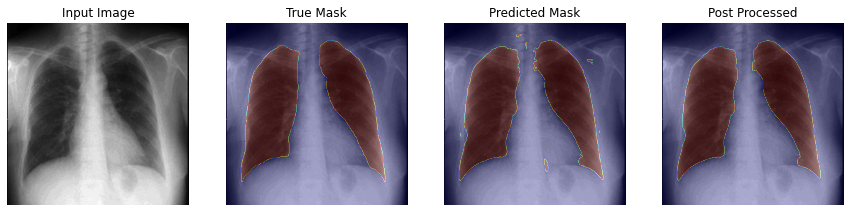

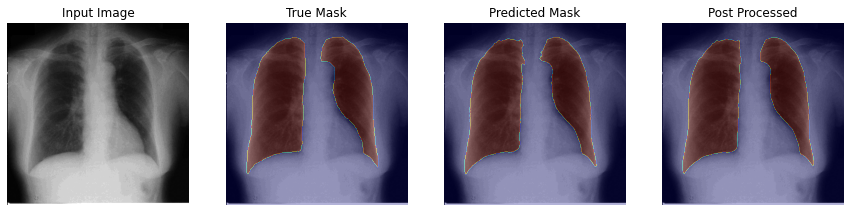

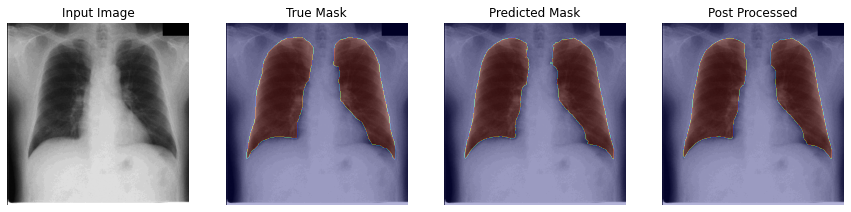

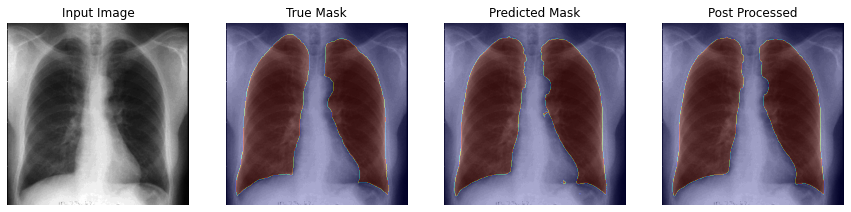

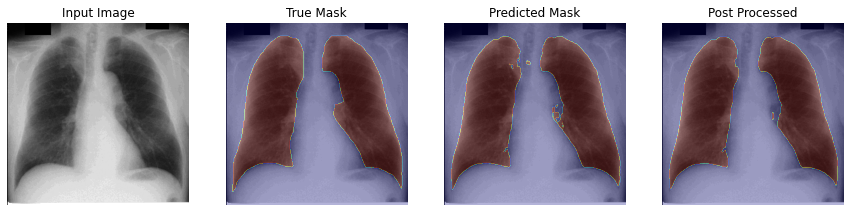

In [130]:
# 훈련이미지와 예측이미지 비교
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            PostProcess = pprocess((np.array(create_mask(pred_mask))[:,:,0]*255).astype('uint8'), SE = (5, 20), thresh = 5000)[:, :, newaxis]
            display_alpha([image[0], mask[0], create_mask(pred_mask), PostProcess])
    else:
        display_alpha([sample_image, sample_mask/128, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(val_test_dataset, 10)

In [45]:
img.max()

1

In [30]:
original_img = cv2.imread('SampleImage/sampleOutput.png',0)

SE = [(2, 10), (5, 20), (10, 30), (10, 50)]
Threshold = [3000, 6000]

processed_imgs = [original_img]
for _SE in SE:
    for _Threshold in Threshold:
        processed_imgs.append(pprocess(original_img, _SE, _Threshold))